In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import datetime
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import plotly.express as px

In [3]:
df = pd.read_csv('full_month_grid.csv')

In [4]:
df.head()

time           rate
0  2013-11-01 00:00:00  710841.049680
1  2013-11-01 00:10:00  689606.902359
2  2013-11-01 00:20:00  673841.228490
3  2013-11-01 00:30:00  641464.168550
4  2013-11-01 00:40:00  623366.124033

In [5]:
df.shape

(8928, 2)

<AxesSubplot:xlabel='rate'>

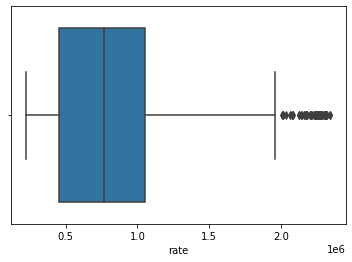

In [6]:
sns.boxplot(x=df['rate'])

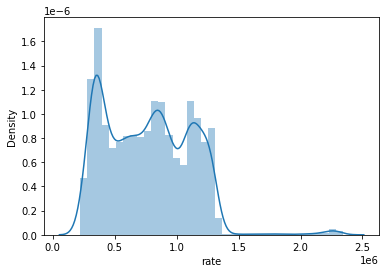

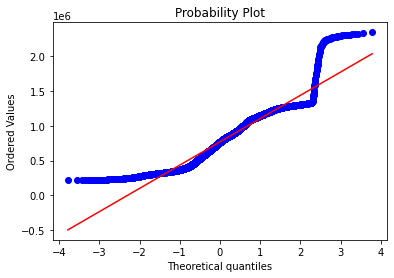

In [7]:
fig = plt.figure()
ax = fig.gca()
sns.distplot(df['rate'])
plt.show()

#Probability plot
fig = plt.figure()
res = stats.probplot(df['rate'], plot=plt)

In [8]:
df.describe()

rate
count  8.928000e+03
mean   7.694991e+05
std    3.447691e+05
min    2.230003e+05
25%    4.519286e+05
50%    7.683917e+05
75%    1.055704e+06
max    2.342753e+06

## Tukey’s box plot method

-  Tukey distinguishes between possible and probable outliers. 
- 1- A possible outlier is located between the inner and the outer fence, 
- 2- whereas a probable outlier is located outside the outer fence.

<img src="Tukey’s box.png" />


In [9]:
def tukeys_method(df, variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence
    
    #outer fence lower and upper end
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    
    outliers_prob = []
    outliers_poss = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob.append(index)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss.append(index)
    return outliers_prob, outliers_poss
        
probable_outliers_tm, possible_outliers_tm = tukeys_method(df, "rate")

print(probable_outliers_tm)
print("*******************************")
print(possible_outliers_tm)

[]
*******************************
[4518, 4519, 4520, 4521, 4522, 4523, 4524, 4525, 4526, 4527, 4528, 4529, 4530, 4531, 4532, 4533, 4534, 4535, 4536, 4537, 4538, 4539, 4540, 4541, 4542, 4543, 4544, 4545, 4546, 4547, 4548, 4549, 4550, 4551, 4552, 4553, 4554, 4555, 4556, 4557, 4558, 4559, 4560, 4561, 4562, 4563, 4564, 4565, 4566, 4567, 4568, 4569, 4570, 4571, 4572, 4573, 4574, 4575, 4576, 4577, 4578, 4579, 4580, 4581]


In [10]:
len(possible_outliers_tm)

64

## Isolation forest
 Isolation Forest is based on the Decision Tree algorithm. It isolates the outliers by randomly selecting a feature from the given set of features and then randomly selecting a split value between the max and min values of that feature. This random partitioning of features will produce shorter paths in trees for the anomalous data points, thus distinguishing them from the rest of the data.

In general the first step to anomaly detection is to construct a profile of what's "normal", and then report anything that cannot be considered normal as anomalous. However, the isolation forest algorithm does not work on this principle; it does not first define "normal" behavior, and it does not calculate point-based distances.

As you might expect from the name, Isolation Forest instead works by isolating anomalies explicitly isolating anomalous points in the dataset.

The Isolation Forest algorithm is based on the principle that anomalies are observations that are few and different, which should make them easier to identify. Isolation Forest uses an ensemble of Isolation Trees for the given data points to isolate anomalies.

Isolation Forest recursively generates partitions on the dataset by randomly selecting a feature and then randomly selecting a split value for the feature. Presumably the anomalies need fewer random partitions to be isolated compared to "normal" points in the dataset, so the anomalies will be the points which have a smaller path length in the tree, path length being the number of edges traversed from the root node.

In [11]:
df2  = pd.read_csv('full_month_grid.csv', parse_dates=['time'], index_col='time')
df2 = df2.asfreq(pd.infer_freq(df2.index))

In [12]:
import datetime
idx = pd.IndexSlice

In [13]:
df2

rate
time                              
2013-11-01 00:00:00  710841.049680
2013-11-01 00:10:00  689606.902359
2013-11-01 00:20:00  673841.228490
2013-11-01 00:30:00  641464.168550
2013-11-01 00:40:00  623366.124033
...                            ...
2014-01-01 23:10:00  438645.623391
2014-01-01 23:20:00  428536.762595
2014-01-01 23:30:00  417263.649372
2014-01-01 23:40:00  407067.355914
2014-01-01 23:50:00  395190.705498

[8928 rows x 1 columns]

In [14]:
fig = px.line(df2.reset_index(), x='time', y='rate')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(step="all")
        ])
    )
)
fig.show()

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

In [16]:
# train isolation forest

outliers_fraction = float(.01)

scaler = StandardScaler()
np_scaled = scaler.fit_transform(df2.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)

model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 

IsolationForest(contamination=0.01)

In [17]:
df2['anomaly'] = model.predict(data)

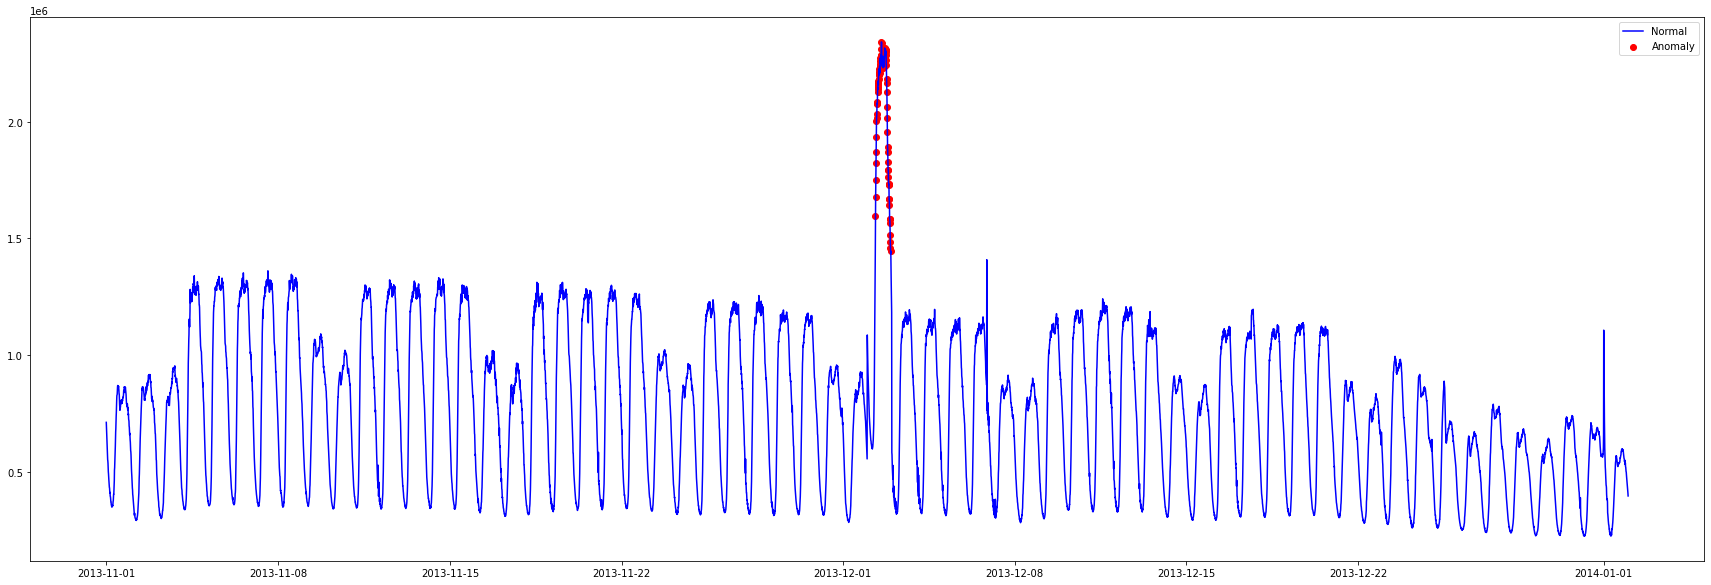

In [18]:
fig, ax = plt.subplots(figsize=(30,10))

anomaly = df2.loc[df2['anomaly'] == -1, ['rate']] 

ax.plot(df2.index, df2['rate'], color='blue', label = 'Normal')
ax.scatter(anomaly.index,anomaly['rate'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

In [19]:
anomaly.size

90

## Anomaly Detection with LSTM Autoencoders

- 1- Train an Autoencoder on normal data (no anomalies)
- 2- Take a new data point and try to reconstruct it using the Autoencoder
- 3- If the error (reconstruction error) for the new data point is above some threshold, we label the example as an anomaly

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [21]:
df = pd.read_csv('full_month_grid.csv', parse_dates=['time'], index_col='time')
df.head()

rate
time                              
2013-11-01 00:00:00  710841.049680
2013-11-01 00:10:00  689606.902359
2013-11-01 00:20:00  673841.228490
2013-11-01 00:30:00  641464.168550
2013-11-01 00:40:00  623366.124033

In [22]:
fig = px.line(df.reset_index(), x='time', y='rate')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(step="all")
        ])
    )
)
fig.show()

In [23]:
train_size = int(len(df) * 0.85)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7588, 1) (1340, 1)


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['rate']])

train['rate'] = scaler.transform(train[['rate']])
test['rate'] = scaler.transform(test[['rate']])

In [25]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [26]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['rate']], train.rate, TIME_STEPS)
X_test, y_test = create_dataset(test[['rate']], test.rate, TIME_STEPS)

print(X_train.shape)

(7558, 30, 1)


In [27]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [28]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/5
213/213 [==============================] - 21s 73ms/step - loss: 0.4181 - val_loss: 0.3001
Epoch 2/5
213/213 [==============================] - 12s 58ms/step - loss: 0.3830 - val_loss: 0.2971
Epoch 3/5
213/213 [==============================] - 13s 61ms/step - loss: 0.3800 - val_loss: 0.2937
Epoch 4/5
213/213 [==============================] - 11s 53ms/step - loss: 0.3726 - val_loss: 0.2880
Epoch 5/5
213/213 [==============================] - 10s 46ms/step - loss: 0.3737 - val_loss: 0.2853


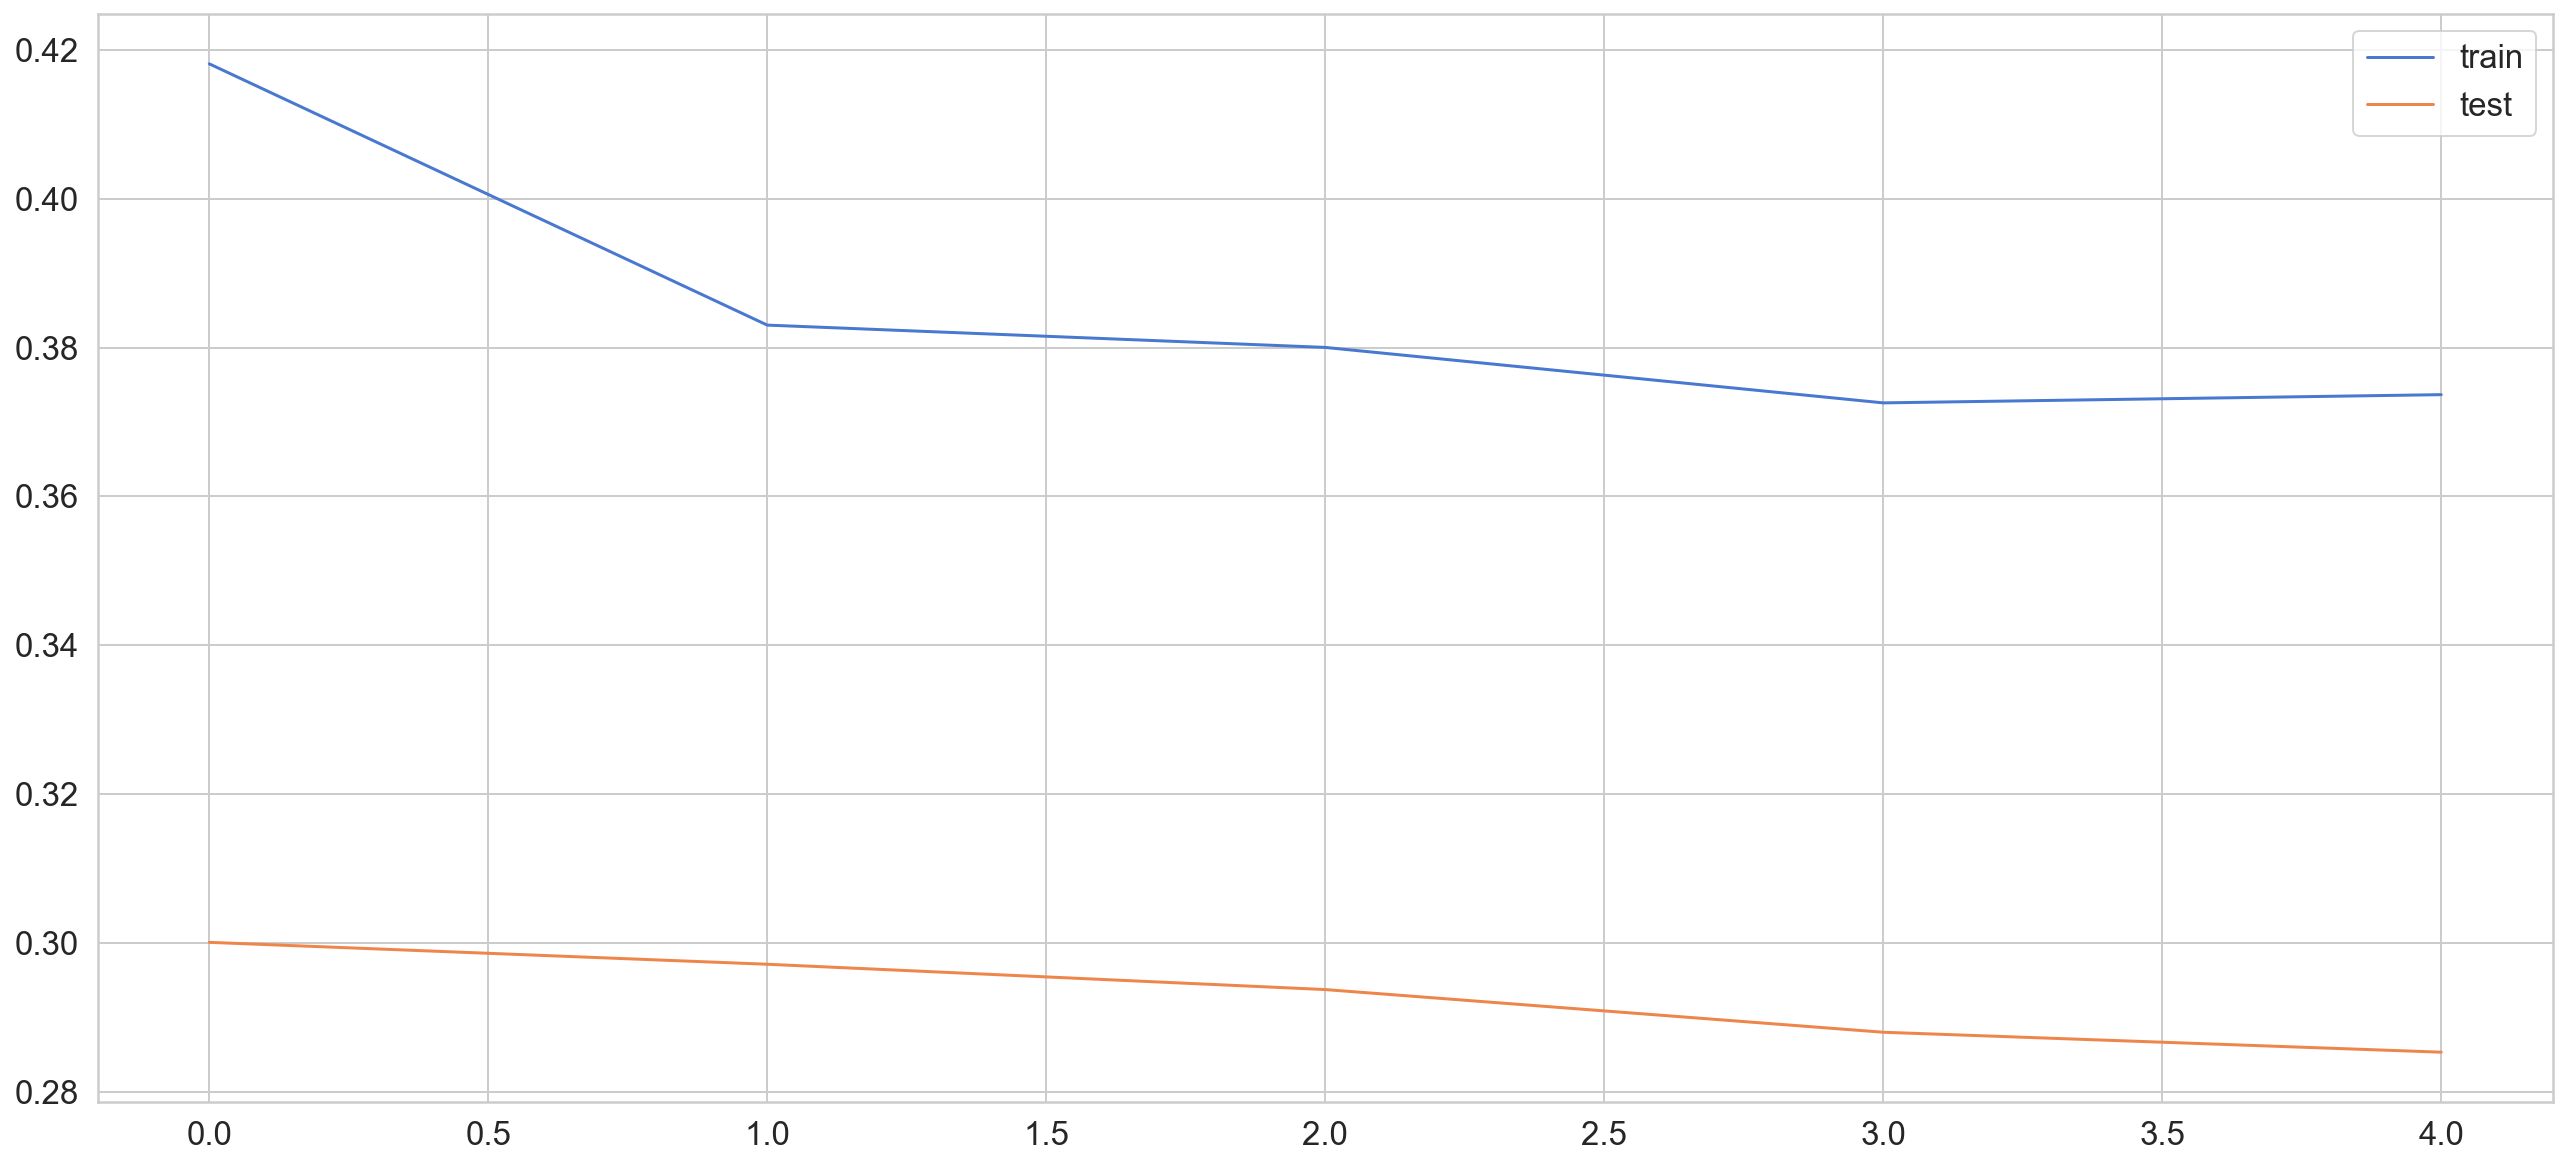

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [30]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [31]:
len(test_mae_loss)

1310

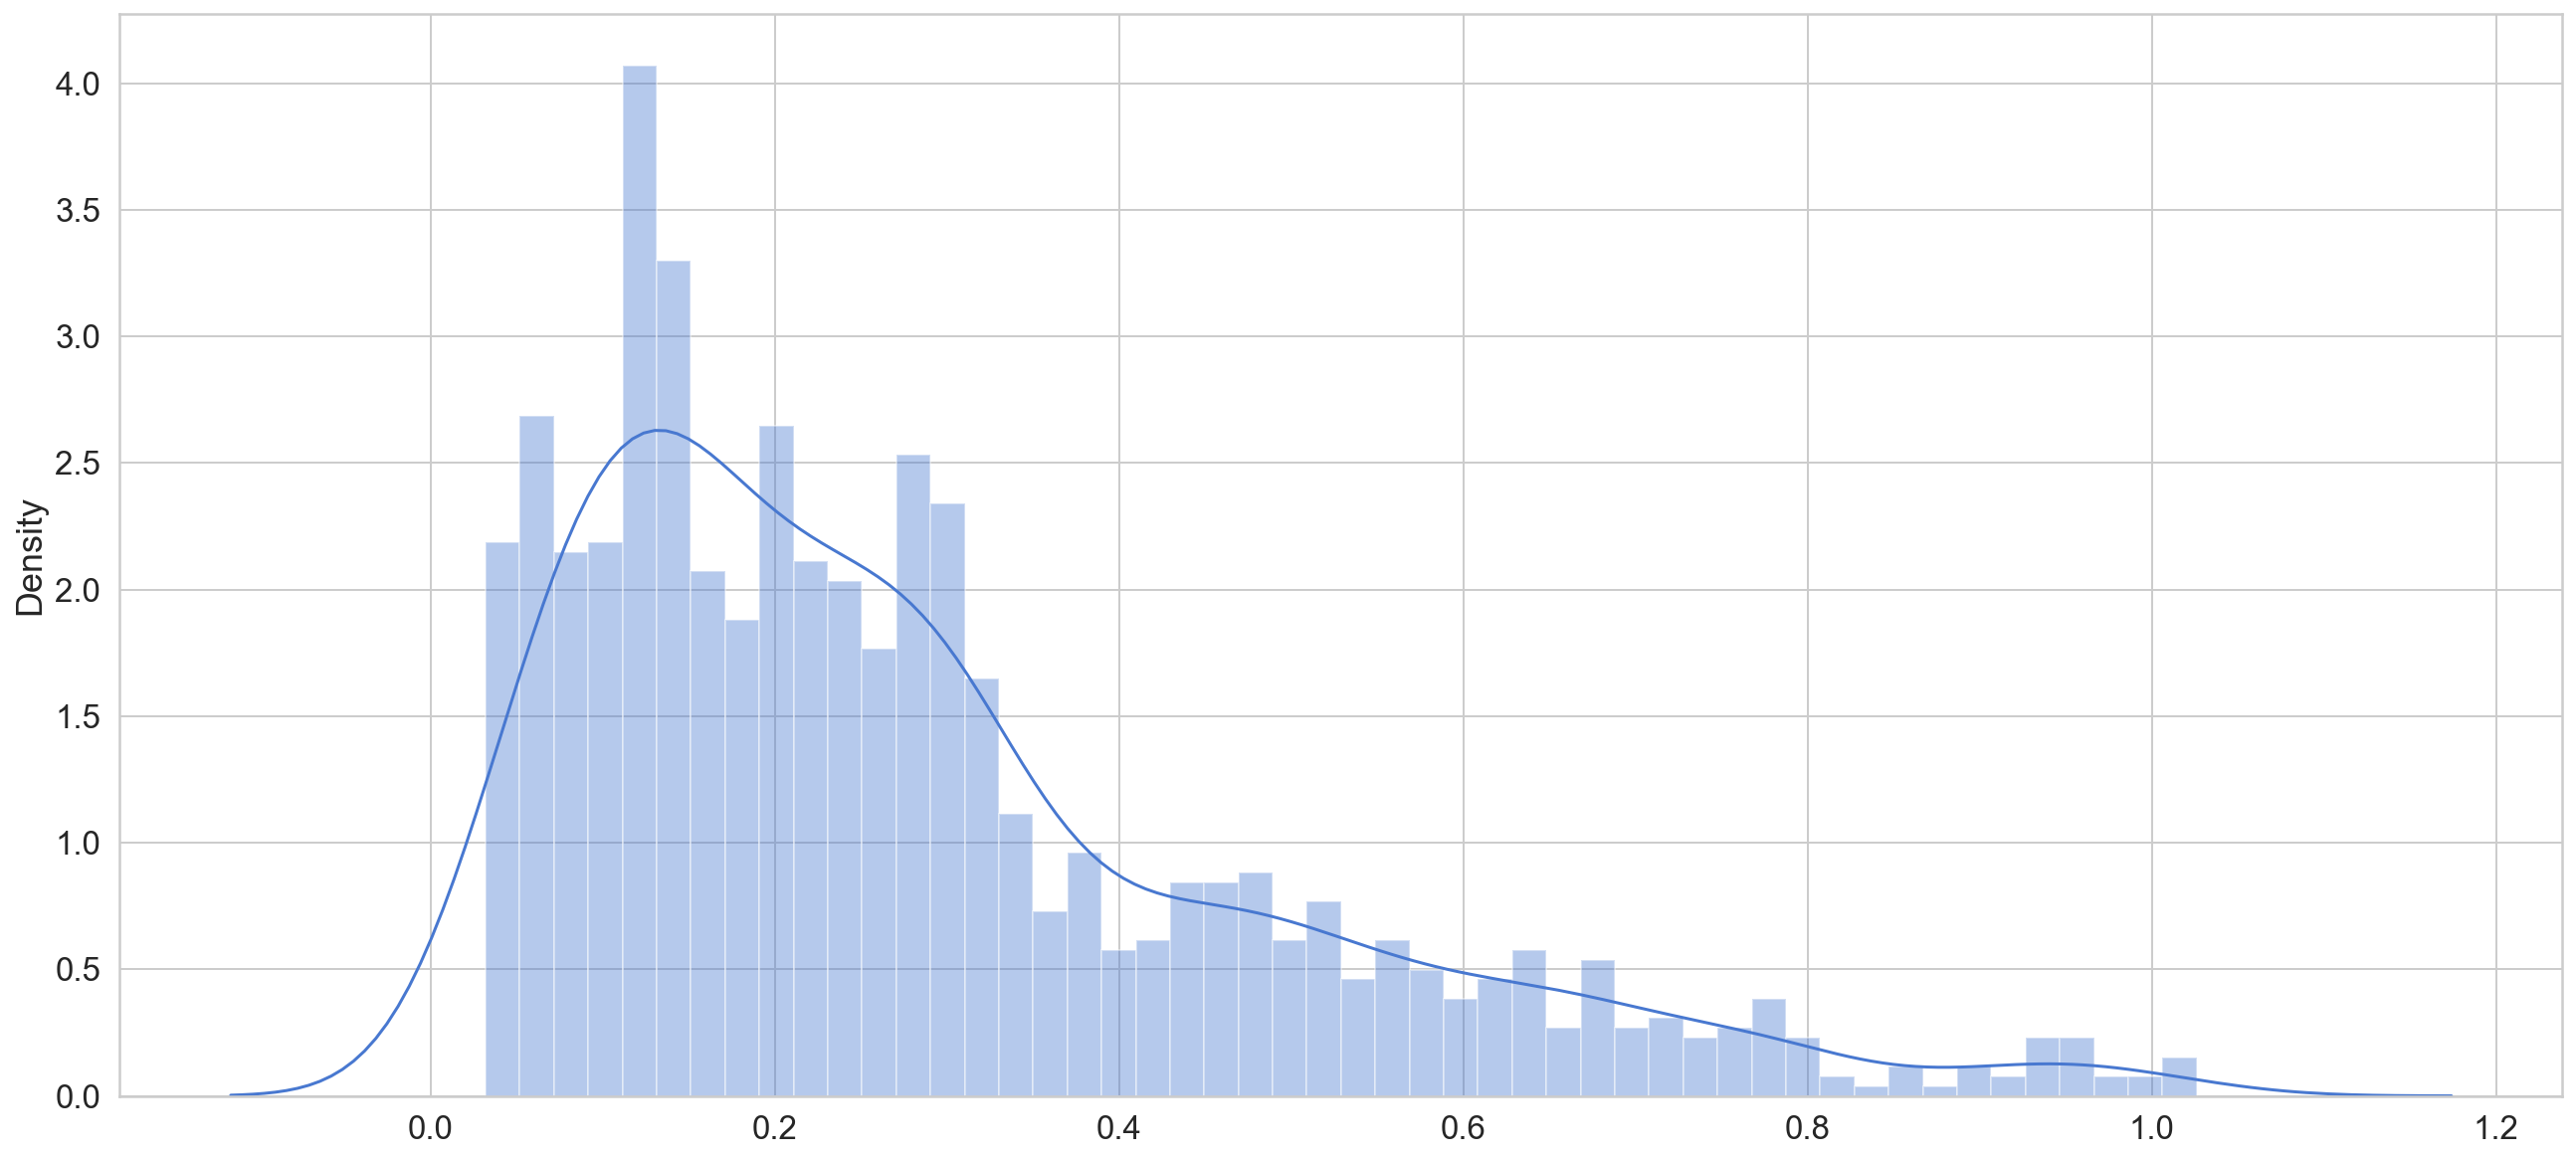

In [32]:
sns.distplot(test_mae_loss, bins=50, kde=True);

In [33]:
THRESHOLD = 0.85

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['rate'] = test[TIME_STEPS:].rate

In [34]:
test_score_df

loss  threshold  anomaly      rate
time                                                       
2013-12-23 21:40:00  0.508497       0.85    False -0.441323
2013-12-23 21:50:00  0.509969       0.85    False -0.463884
2013-12-23 22:00:00  0.507805       0.85    False -0.489948
2013-12-23 22:10:00  0.502818       0.85    False -0.532245
2013-12-23 22:20:00  0.501389       0.85    False -0.553011
...                       ...        ...      ...       ...
2014-01-01 23:10:00  0.204007       0.85    False -1.076461
2014-01-01 23:20:00  0.208315       0.85    False -1.105524
2014-01-01 23:30:00  0.214210       0.85    False -1.137934
2014-01-01 23:40:00  0.221208       0.85    False -1.167248
2014-01-01 23:50:00  0.228494       0.85    False -1.201393

[1310 rows x 4 columns]

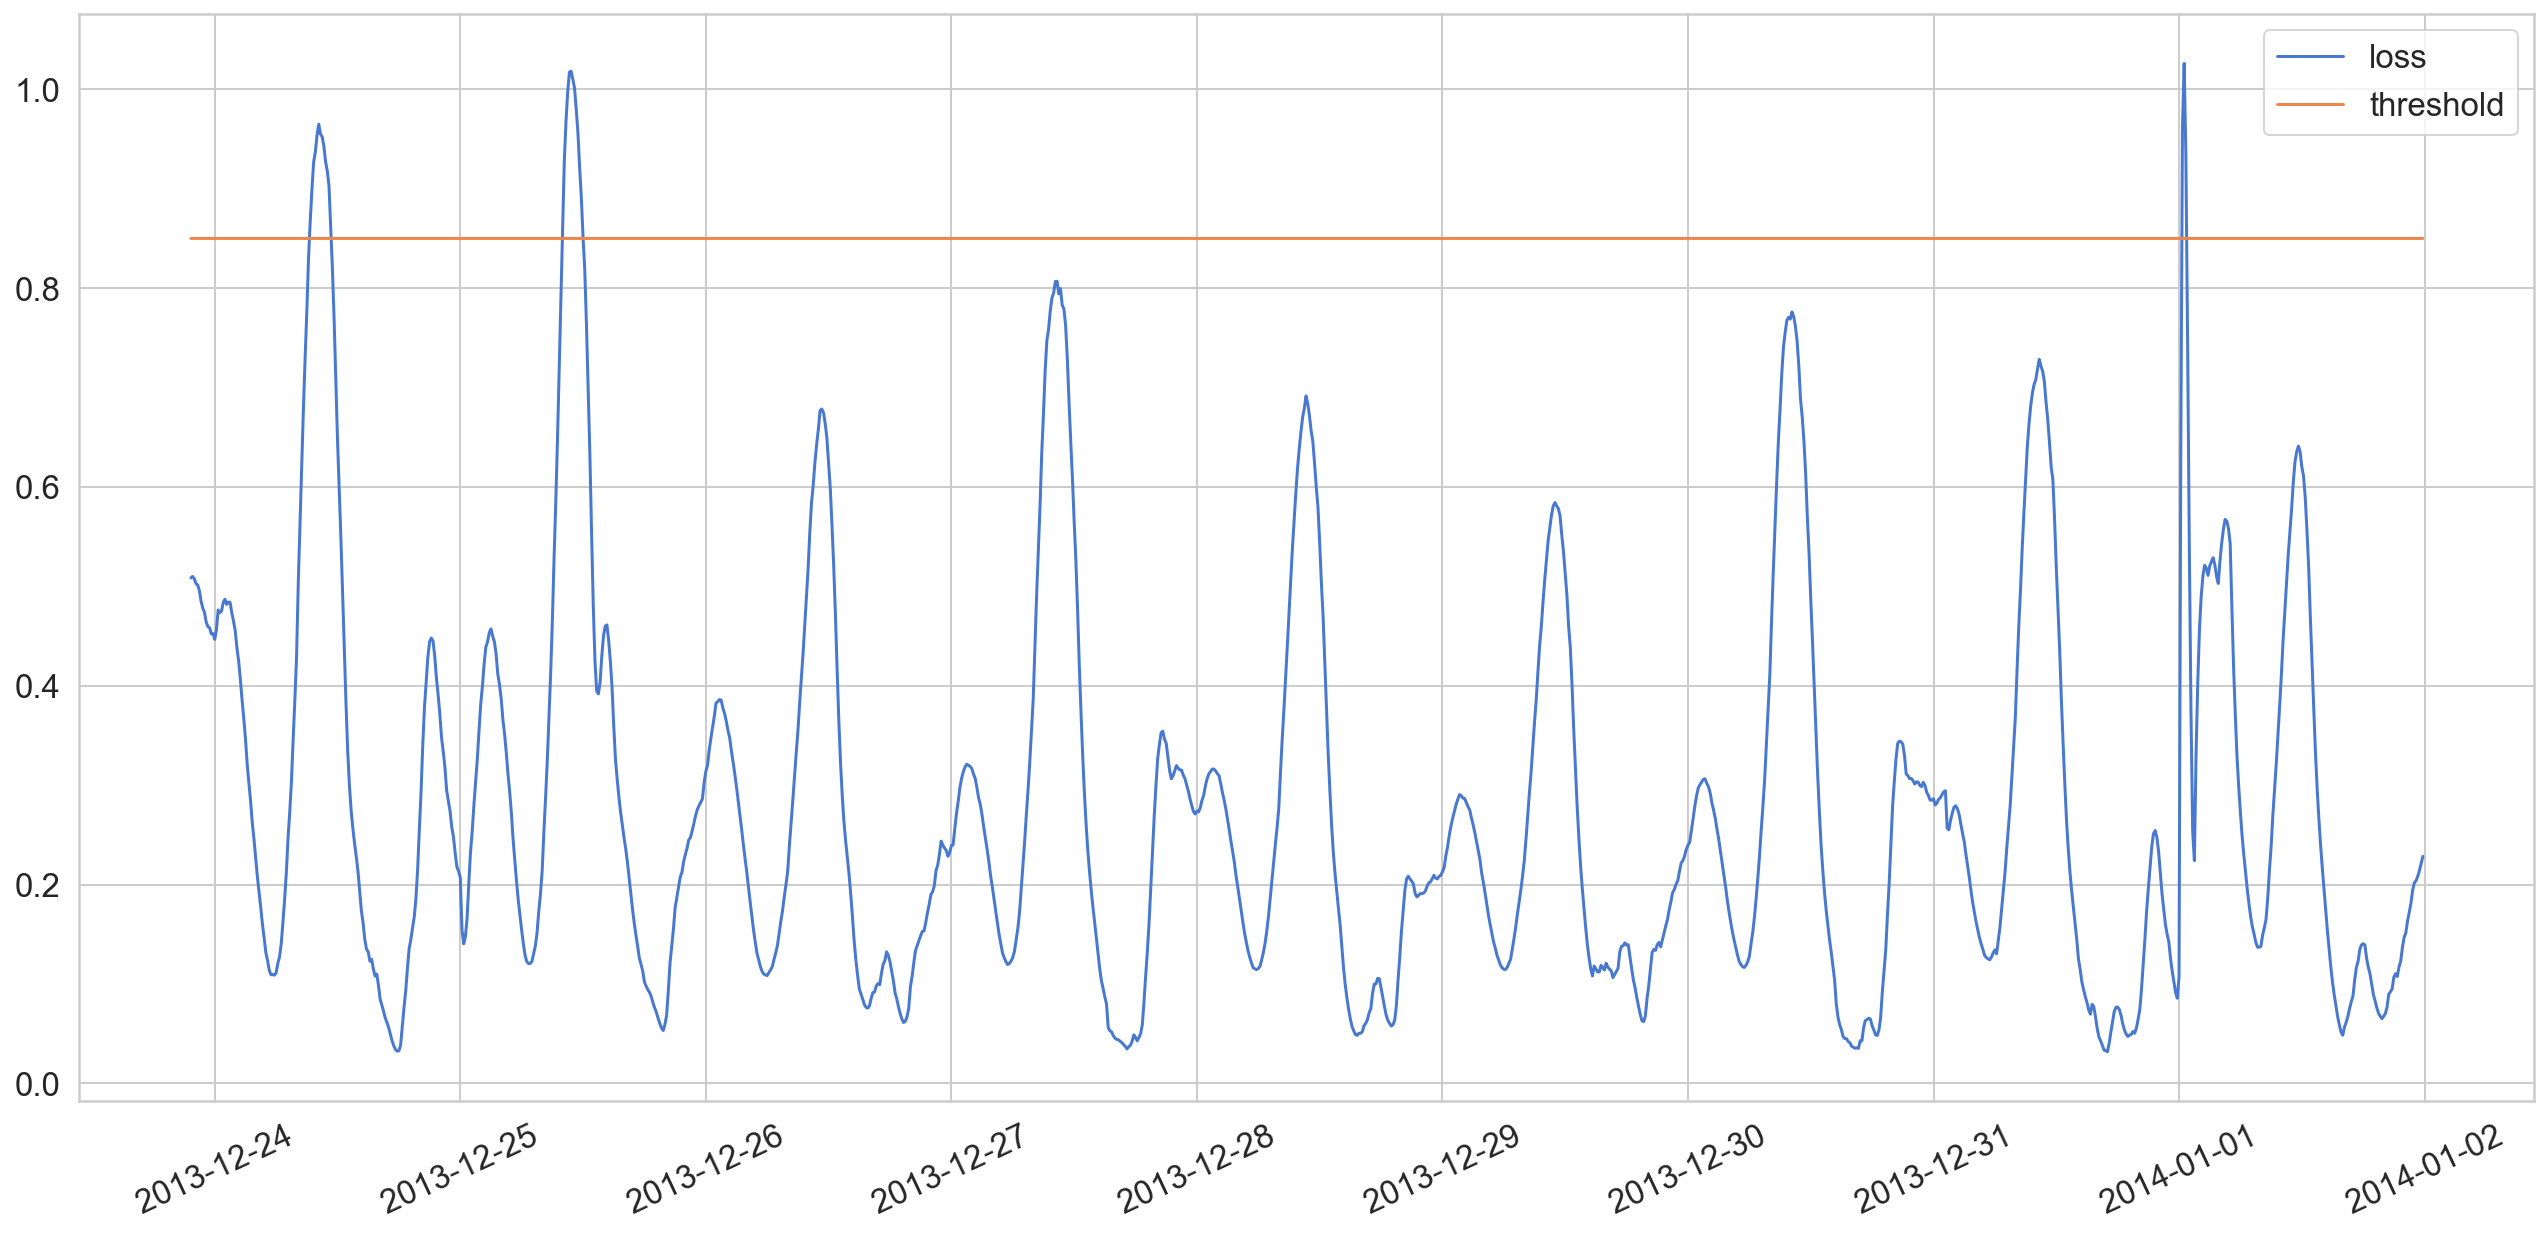

In [35]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [36]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

loss  threshold  anomaly      rate
time                                                       
2013-12-24 09:20:00  0.867438       0.85     True -0.334278
2013-12-24 09:30:00  0.899475       0.85     True -0.253073
2013-12-24 09:40:00  0.926806       0.85     True -0.205556
2013-12-24 09:50:00  0.936973       0.85     True -0.109692
2013-12-24 10:00:00  0.953959       0.85     True -0.042313

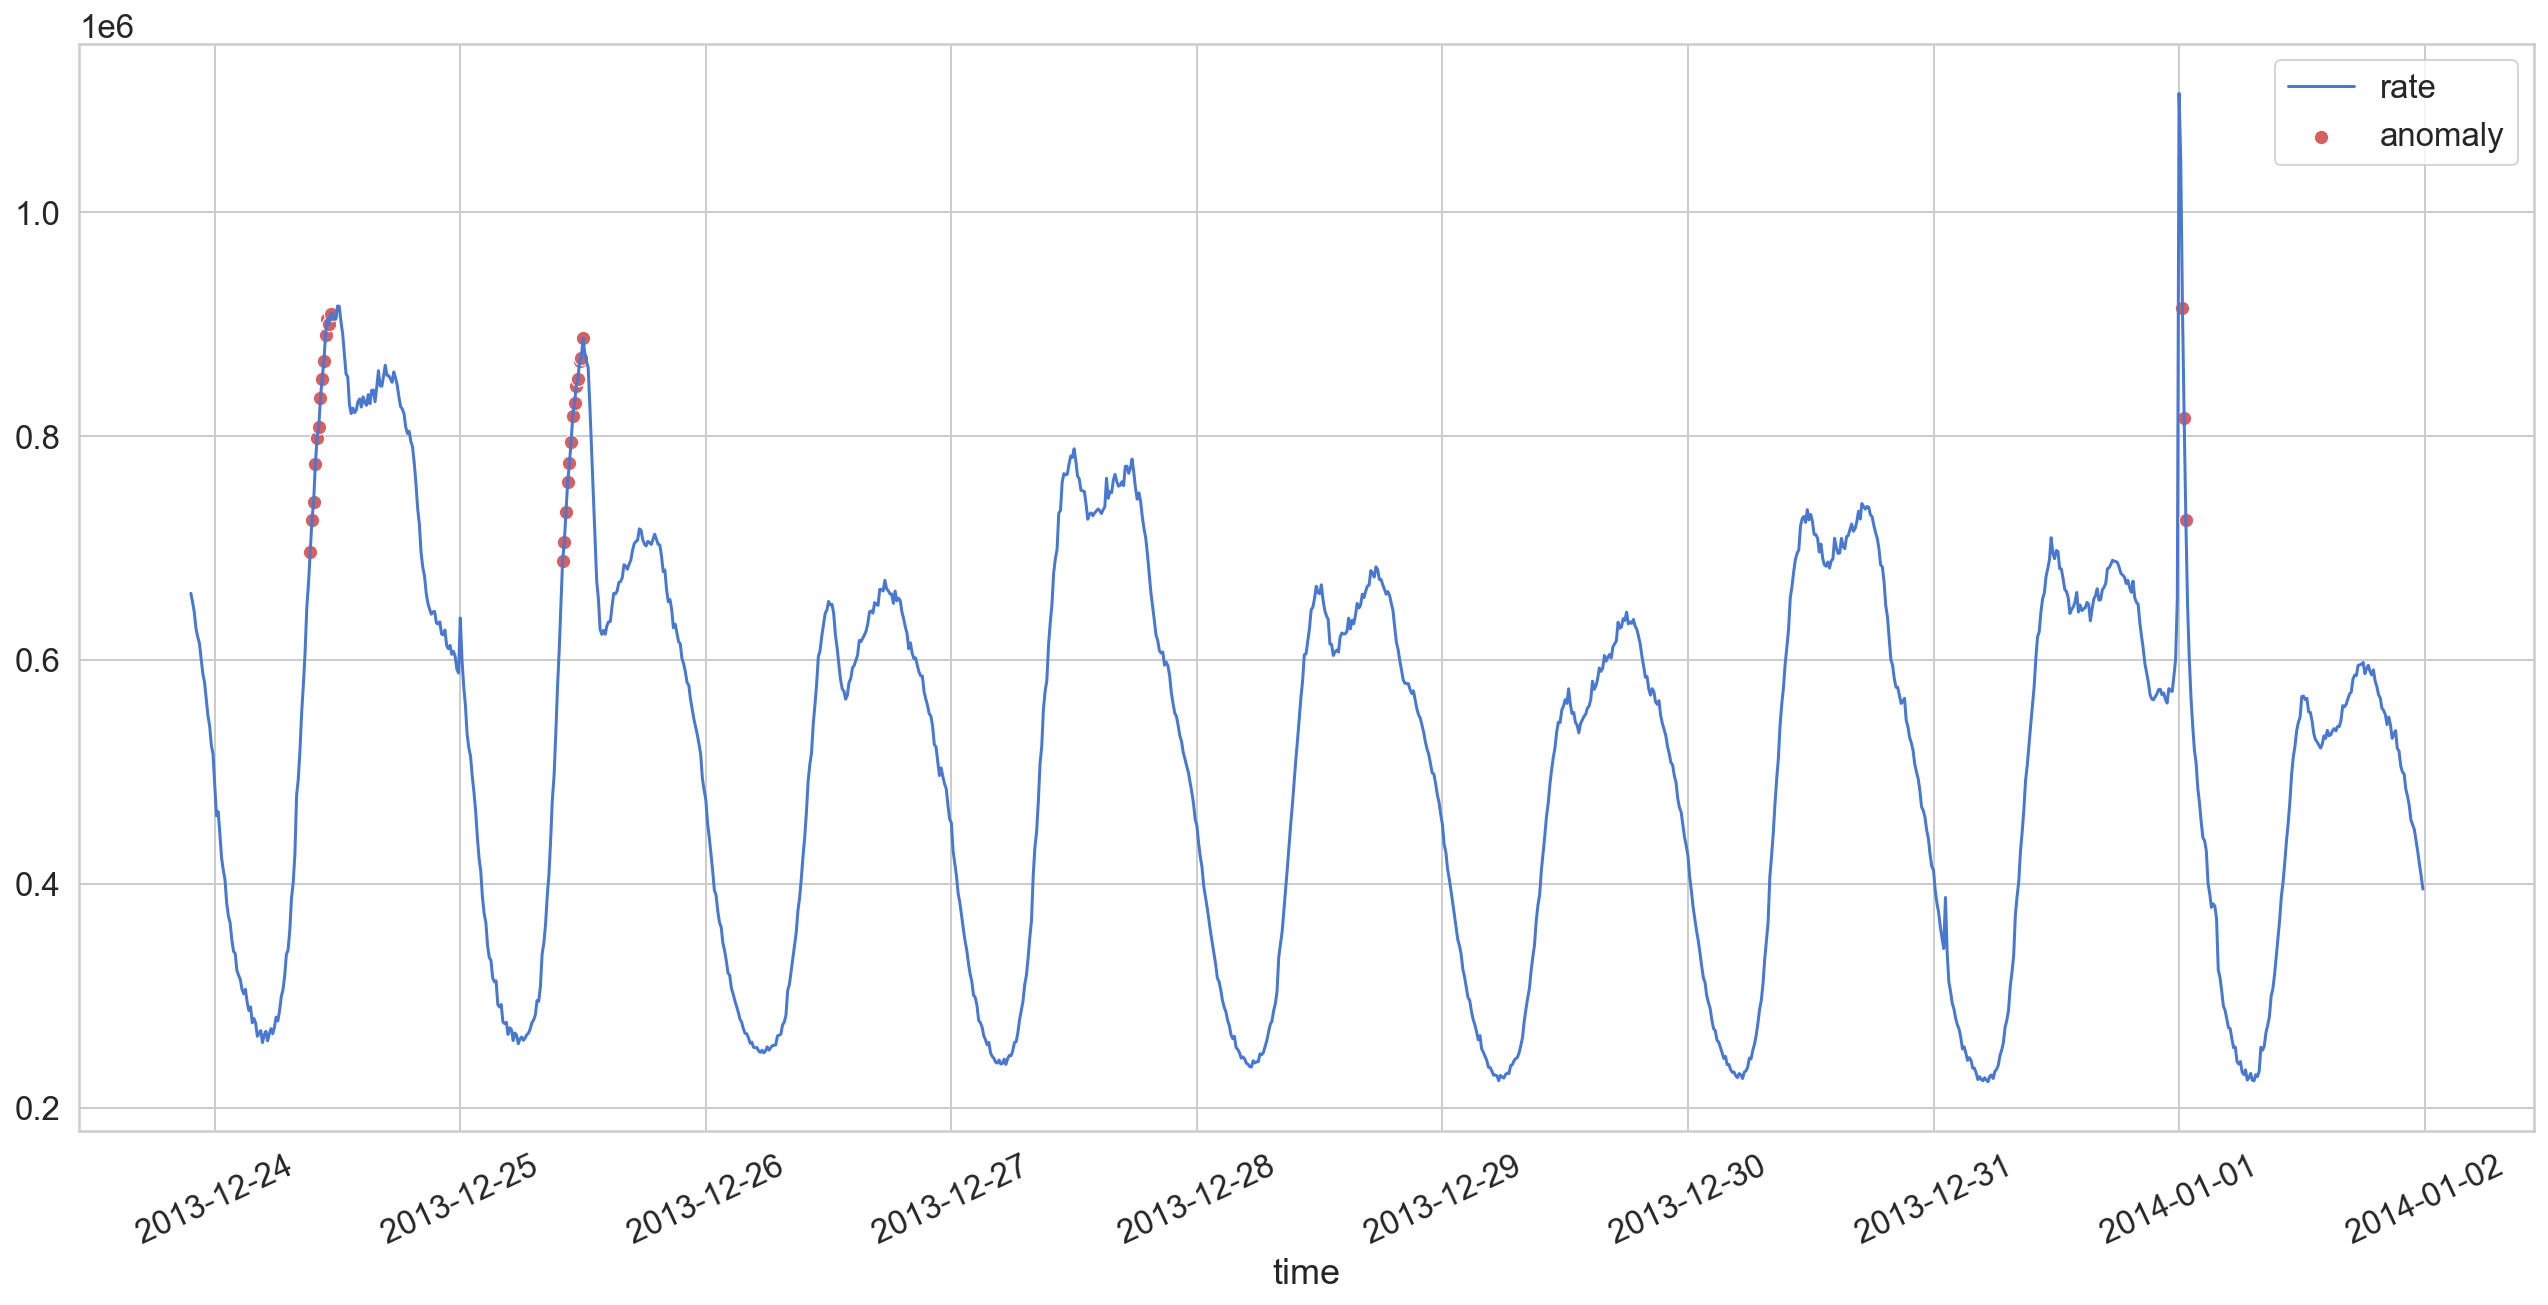

In [37]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].rate), 
  label='rate'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.rate),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

## Anomaly Detection using Prophet

In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [39]:
df = pd.read_csv('full_month_grid.csv')

In [40]:
df['time']=pd.to_datetime(df['time'])

In [41]:
df

time           rate
0    2013-11-01 00:00:00  710841.049680
1    2013-11-01 00:10:00  689606.902359
2    2013-11-01 00:20:00  673841.228490
3    2013-11-01 00:30:00  641464.168550
4    2013-11-01 00:40:00  623366.124033
...                  ...            ...
8923 2014-01-01 23:10:00  438645.623391
8924 2014-01-01 23:20:00  428536.762595
8925 2014-01-01 23:30:00  417263.649372
8926 2014-01-01 23:40:00  407067.355914
8927 2014-01-01 23:50:00  395190.705498

[8928 rows x 2 columns]

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8928 entries, 0 to 8927
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    8928 non-null   datetime64[ns]
 1   rate    8928 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 139.6 KB


In [43]:
fig = px.line(df.reset_index(), x='time', y='rate')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(step="all")
        ])
    )
)
fig.show()

In [99]:
from fbprophet import Prophet

In [100]:
df3=df.reset_index()[['time','rate']].rename({'time':'ds','rate':'y'}, axis='columns')

In [101]:
df3

ds              y
0    2013-11-01 00:00:00  710841.049680
1    2013-11-01 00:10:00  689606.902359
2    2013-11-01 00:20:00  673841.228490
3    2013-11-01 00:30:00  641464.168550
4    2013-11-01 00:40:00  623366.124033
...                  ...            ...
8923 2014-01-01 23:10:00  438645.623391
8924 2014-01-01 23:20:00  428536.762595
8925 2014-01-01 23:30:00  417263.649372
8926 2014-01-01 23:40:00  407067.355914
8927 2014-01-01 23:50:00  395190.705498

[8928 rows x 2 columns]

In [102]:
train = int(len(df3) * 0.7)
test = len(df3) - train
train, test = df3.iloc[0:train], df3.iloc[train:len(df3)]
print(train.shape, test.shape)

(6249, 2) (2679, 2)


In [103]:
m = Prophet(changepoint_range=0.95)

In [104]:
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [105]:
future = m.make_future_dataframe(periods=432,freq='H')
future.tail()

ds
6676 2014-01-01 05:20:00
6677 2014-01-01 06:20:00
6678 2014-01-01 07:20:00
6679 2014-01-01 08:20:00
6680 2014-01-01 09:20:00

In [106]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
6676 2014-01-01 05:20:00  3.467404e+05 -2.335483e+06  2.779475e+06
6677 2014-01-01 06:20:00  4.365238e+05 -2.204451e+06  2.818331e+06
6678 2014-01-01 07:20:00  6.063289e+05 -2.143932e+06  3.042737e+06
6679 2014-01-01 08:20:00  8.192766e+05 -1.938578e+06  3.252744e+06
6680 2014-01-01 09:20:00  1.013742e+06 -1.741327e+06  3.483564e+06

In [107]:
results=pd.concat([df3.set_index('ds')['y'],forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]],axis=1)

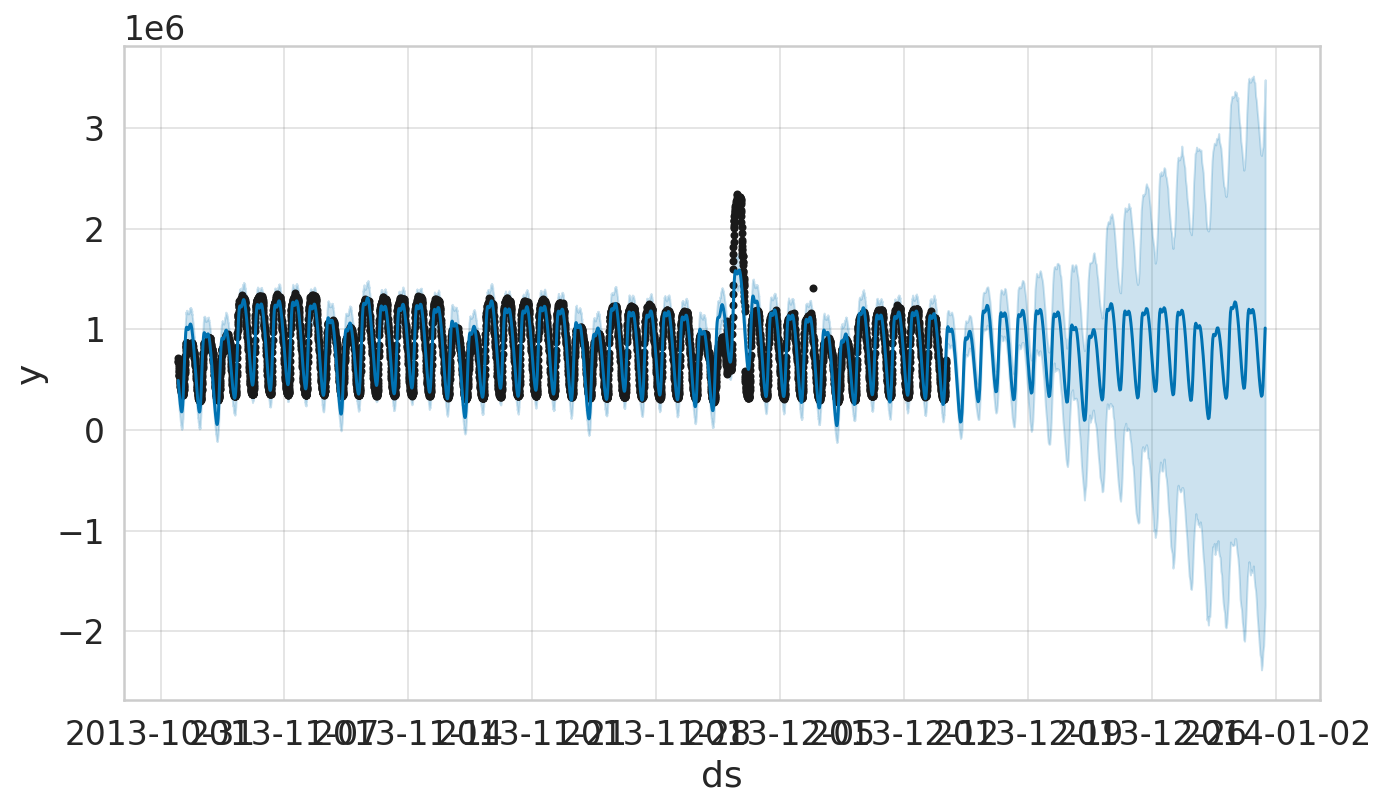

In [108]:
fig1 = m.plot(forecast)

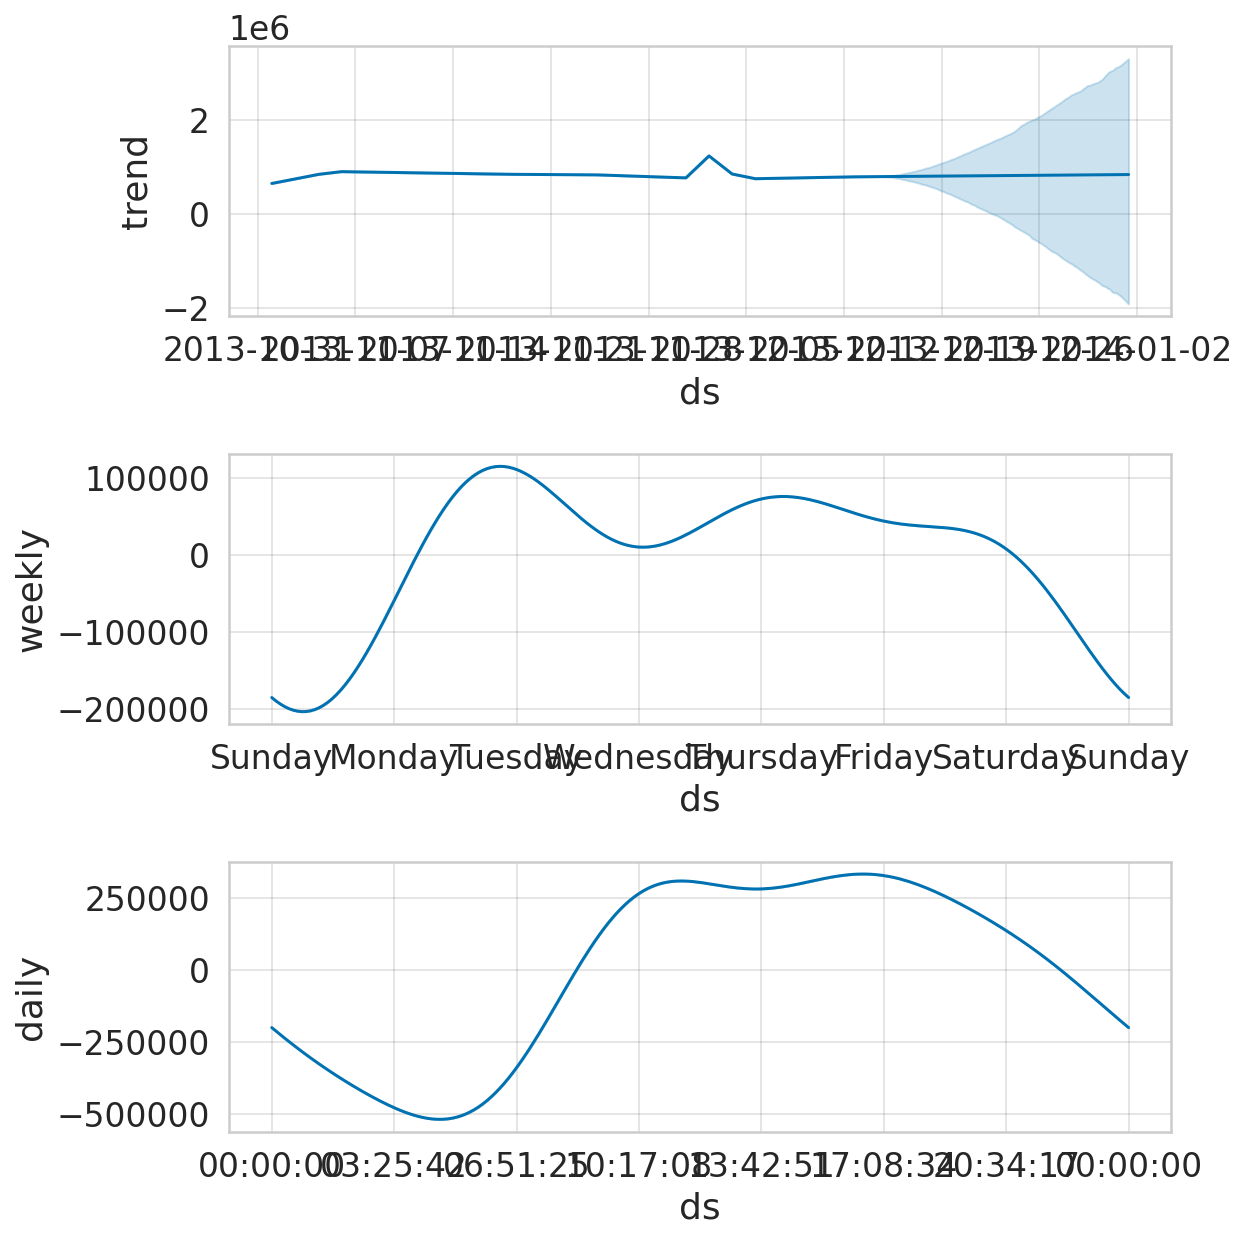

In [109]:
comp=m.plot_components(forecast)

In [110]:
results

y           yhat     yhat_lower     yhat_upper
ds                                                                             
2013-11-01 00:00:00  710841.049680  492634.347365  328424.764116  662399.194484
2013-11-01 00:10:00  689606.902359  475715.149050  318721.962912  644514.670061
2013-11-01 00:20:00  673841.228490  459101.080402  296091.860852  621171.697797
2013-11-01 00:30:00  641464.168550  442823.660240  284586.682624  596592.444193
2013-11-01 00:40:00  623366.124033  426906.797956  265332.562081  582491.330261
...                            ...            ...            ...            ...
2014-01-01 23:10:00  438645.623391            NaN            NaN            NaN
2014-01-01 23:20:00  428536.762595            NaN            NaN            NaN
2014-01-01 23:30:00  417263.649372            NaN            NaN            NaN
2014-01-01 23:40:00  407067.355914            NaN            NaN            NaN
2014-01-01 23:50:00  395190.705498            NaN            NaN            NaN

[8928 rows x 4 columns]

In [111]:
results['error'] = results['y'] - results['yhat']

In [112]:
results["uncertainty"] = results['yhat_upper'] - results['yhat_lower']

In [113]:
results

y           yhat  ...          error    uncertainty
ds                                                 ...                              
2013-11-01 00:00:00  710841.049680  492634.347365  ...  218206.702315  333974.430368
2013-11-01 00:10:00  689606.902359  475715.149050  ...  213891.753310  325792.707148
2013-11-01 00:20:00  673841.228490  459101.080402  ...  214740.148088  325079.836945
2013-11-01 00:30:00  641464.168550  442823.660240  ...  198640.508310  312005.761569
2013-11-01 00:40:00  623366.124033  426906.797956  ...  196459.326077  317158.768180
...                            ...            ...  ...            ...            ...
2014-01-01 23:10:00  438645.623391            NaN  ...            NaN            NaN
2014-01-01 23:20:00  428536.762595            NaN  ...            NaN            NaN
2014-01-01 23:30:00  417263.649372            NaN  ...            NaN            NaN
2014-01-01 23:40:00  407067.355914            NaN  ...            NaN            NaN
2014-01-01 23:50:00  395190.705498            NaN  ...            NaN            NaN

[8928 rows x 6 columns]

In [114]:
results[results['error'].abs() >  1.5*results['uncertainty']]

y          yhat  ...          error    uncertainty
ds                                               ...                              
2013-12-02 08:20:00  1.750513e+06  1.231782e+06  ...  518731.216554  302752.317766
2013-12-02 08:30:00  1.821296e+06  1.266828e+06  ...  554468.405321  328461.658370
2013-12-02 08:40:00  1.868925e+06  1.301008e+06  ...  567916.595820  339678.199943
2013-12-02 08:50:00  1.934915e+06  1.334035e+06  ...  600879.441463  321699.293198
2013-12-02 09:00:00  2.003883e+06  1.365640e+06  ...  638243.266349  314872.084933
...                           ...           ...  ...            ...            ...
2013-12-02 19:10:00  2.126416e+06  1.475185e+06  ...  651230.980592  319383.709514
2013-12-02 19:20:00  2.065399e+06  1.462996e+06  ...  602403.302393  331901.404528
2013-12-02 19:30:00  2.016192e+06  1.450468e+06  ...  565724.171148  316596.387989
2013-12-02 19:40:00  1.957523e+06  1.437618e+06  ...  519904.893889  321345.073912
2013-12-06 20:50:00  1.408543e+06  8.937467e+05  ...  514796.039062  324428.978670

[70 rows x 6 columns]

In [115]:
results['anomaly'] = results.apply(lambda x: 'Yes' if(np.abs(x['error']) >  1.5*x['uncertainty']) else 'No', axis=1)

In [116]:
results

y           yhat  ...    uncertainty  anomaly
ds                                                 ...                        
2013-11-01 00:00:00  710841.049680  492634.347365  ...  333974.430368       No
2013-11-01 00:10:00  689606.902359  475715.149050  ...  325792.707148       No
2013-11-01 00:20:00  673841.228490  459101.080402  ...  325079.836945       No
2013-11-01 00:30:00  641464.168550  442823.660240  ...  312005.761569       No
2013-11-01 00:40:00  623366.124033  426906.797956  ...  317158.768180       No
...                            ...            ...  ...            ...      ...
2014-01-01 23:10:00  438645.623391            NaN  ...            NaN       No
2014-01-01 23:20:00  428536.762595            NaN  ...            NaN       No
2014-01-01 23:30:00  417263.649372            NaN  ...            NaN       No
2014-01-01 23:40:00  407067.355914            NaN  ...            NaN       No
2014-01-01 23:50:00  395190.705498            NaN  ...            NaN       No

[8928 rows x 7 columns]

In [117]:
fig = px.scatter(results.reset_index(), x='ds', y='y', color='anomaly')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(step="all")
        ])
    )
)
fig.show()